# **6.1.3 VGGNet**

## **1. 라이브러리 호출**

In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### **객체 복사**

```import copy``` : **객체 복사**를 위해 사용함.
1. 단순 객체 복사
2. 크게 얕은 복사(shallow copy)
3. 깊은 복사(deep copy)

**1. 단순 객체 복사**

In [2]:
original=[1, 2, 3]
copy_o=original
print(copy_o)

copy_o[2]=10
print(copy_o)
print(original)

[1, 2, 3]
[1, 2, 10]
[1, 2, 10]


✅`copy_o`와 `original` 모두 바뀐다.

**2. 얕은 복사**

In [3]:
import copy

original=[[1, 2], 3]
copy_o=copy.copy(original)
print(copy_o)
copy_o[0]=100
print(copy_o)

append=copy.copy(original)
append[0].append(4)
print(append)
print(original)

[[1, 2], 3]
[100, 3]
[[1, 2, 4], 3]
[[1, 2, 4], 3]


✅`copy_o`에서 `[1, 2]` 값을 `100`으로 변경했더니 `copy_o`만 바뀌었다.

✅`[1, 2]`에 `4`를 추가했더니 `original`과 `copy_o` 모두 바뀌었다.

**3. 깊은 복사**

In [4]:
import copy

original=[[1, 2], 3]
copy_o=copy.deepcopy(original)
print(copy_o)
copy_o[0]=100
print(copy_o)
print(original)

append=copy.deepcopy(original)
append[0].append(4)
print(append)
print(original)

[[1, 2], 3]
[100, 3]
[[1, 2], 3]
[[1, 2, 4], 3]
[[1, 2], 3]


✅`copy_o`은 변경되었지만 `original`은 그대로이다.

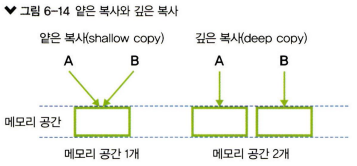

## **2. VGG 모델 정의**

In [5]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super().__init__()
    self.features=features
    self.avgpool=nn.AdaptiveAvgPool2d(7)
    self.classifier=nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        ## 마지막 층
        nn.Dropout(0.5),
        nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    x=self.features(x)
    x=self.avgpool(x)
    h=x.view(x.shape[0], -1)
    x=self.classifier(h)
    return x, h

**VGG11, VGG13, VGG16, VGG19 모델의 계층 정의**
* 숫자(output channel, 출력 채널)는 Conv2d를 수행하라는 의미
* 출력 채널(output channel)은 다음 계층의 입력 채널(input channel)
* ❓`M` : 최대 풀링(max pooling)

In [6]:
vgg11_config=[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg13_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg16_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg19_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

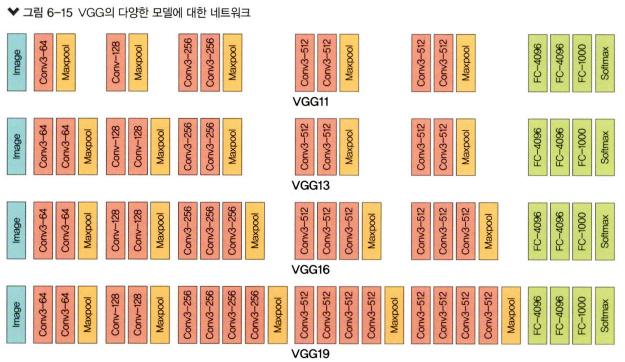

**VGG 계층 정의**

In [7]:
def get_vgg_layers(config, batch_norm):
  layers=[]
  in_channels=3

  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c=='M':
      layers += [nn.MaxPool2d(kernel_size=2)]
    else:
      conv2d=nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
      else:
        layers += [conv2d, nn.ReLU(inpalce=True)]
      in_channels=c

  return nn.Sequential(*layers) # 네트워크의 모든 계층 반환

In [8]:
print(isinstance(1, int))
print(isinstance(1.2, int))
print(isinstance('deep learning', str))

True
False
True


In [9]:
vgg11_layers=get_vgg_layers(vgg11_config, batch_norm=True)

In [10]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

➡️배치 정규화(`BatchNorm2d`) 추가 확인

**VGG11 전체에 대한 네트워크 확인**

In [11]:
OUTPUT_DIM=2
model=VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

➡️
`vgg11_layers`와 `VGG()`에서 정의했던 완전연결층과 출력층이 포함된 구성 : `vgg11_layers`, 완전연결층, 출력층이 합쳐졌다.

**VGG11 사전 훈련된 모델 사용**

VGG 모델은 사전 훈련된 모델이다.
* 사전 훈련된 모델 : 이미 누군가가 대용량의 이미지 데이터로 학습을 시켰으며, 최상의 상태로 튜닝을 거쳐 모든 사람이 사용할 수 있도록 공유한 모델

In [12]:
import torchvision.models as models

pretrained_model=models.vgg11_bn(pretrained=True)
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [13]:
vgg11_config=[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg13_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg16_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg19_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
My_Vgg=[64, 64, 64, 'M', 128, 128, 128, 'M', 256, 256, 256, 'M']

## **3. 이미지 전처리**

In [14]:
train_transforms=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**ImageFolder를 이용하여 데이터셋 불러오기**

In [16]:
train_path='/content/drive/MyDrive/24-2/EURON/과제/Week8/catanddog/train'
test_path='/content/drive/MyDrive/24-2/EURON/과제/Week8/catanddog/test'

train_dataset=torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset=torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

529
12


(None, None)

**훈련과 검증 데이터 분할**

In [17]:
VALID_RATIO=0.9
n_train_examples=int(len(train_dataset)*VALID_RATIO)
n_valid_examples=len(train_dataset)-n_train_examples

train_data, valid_data=data.random_split(train_dataset,
                                         [n_train_examples, n_valid_examples])

**검증 데이터 전처리**

In [18]:
valid_data=copy.deepcopy(valid_data)
valid_data.dataset.transform=test_transforms

**훈련, 검증, 테스트 데이터셋 수 확인**

In [19]:
print(f'Number of training examples : {len(train_data)}')
print(f'Number of validation examples : {len(valid_data)}')
print(f'Number of testing examples : {len(test_dataset)}')

Number of training examples : 476
Number of validation examples : 53
Number of testing examples : 12


**메모리로 데이터 불러오기**

In [20]:
BATCH_SIZE=16
train_iterator=data.DataLoader(train_data,
                               shuffle=True, # 임의로 섞어서 가져온다.
                               batch_size=BATCH_SIZE)

valid_iterator=data.DataLoader(valid_data,
                               batch_size=BATCH_SIZE)

test_iterator=data.DataLoader(test_dataset,
                              batch_size=BATCH_SIZE)

**옵티마이저, 손실 함수 정의**

In [21]:
optimizer=optim.Adam(model.parameters(), lr=1e-7)
criterion=nn.CrossEntropyLoss()

model=model.to(device)
criterion=criterion.to(device)

**모델 정확도 측정 함수**

In [22]:
def calculate_accuracy(y_pred, y):
  top_pred=y_pred.argmax(1, keepdim=True)
  correct=top_pred.eq(y.view_as(top_pred)).sum()
  acc=correct.float()/y.shape[0]
  return acc

**모델 학습 함수 정의**

In [23]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss=0
  epoch_acc=0

  model.train()
  for (x, y) in iterator:
    x=x.to(device)
    y=y.to(device)

    optimizer.zero_grad()
    y_pred, _=model(x)
    loss=criterion(y_pred, y)
    acc=calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

**모델 성능 측정 함수**

In [24]:
def evaluate(model, iterator, criterion, device):
  epoch_loss=0
  epoch_acc=0

  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x=x.to(device)
      y=y.to(device)
      y_pred, _=model(x)
      loss=criterion(y_pred, y)
      acc=calculate_accuracy(y_pred, y)
      epoch_loss+=loss.item()
      epoch_acc+=acc.item()
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

**학습 시간 측정 함수**

In [25]:
def epoch_time(start_time, end_time):
  elapsed_time=end_time-start_time
  elapsed_mins=int(elapsed_time/60)
  elapsed_secs=int(elapsed_time-(elapsed_mins*60))
  return elapsed_mins, elapsed_secs

**모델 학습**

In [26]:
import time

EPOCHS=5
best_valid_loss=float('inf')
for epoch in range(EPOCHS):
  start_time=time.monotonic()
  train_loss, train_acc=train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc=evaluate(model, valid_iterator, criterion, device)

  # valid_loss가 가장 작은 값을 VGG-model.pt 이름으로 저장
  if valid_loss<best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(), 'VGG-model.pt')

  end_time=time.monotonic()
  epoch_mins, epoch_secs=epoch_time(start_time, end_time)

  print(f'Epoch : {epoch+1:02} | Epoch Time : {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss : {train_loss:.3f} | Train Acc : {train_acc*100:.2f}%')
  print(f'\t Valid. Loss : {valid_loss:.3f} | Valid, Acc : {valid_acc*100:.2f}%')

Epoch : 01 | Epoch Time : 13m 49s
	Train Loss : 0.702 | Train Acc : 51.60%
	 Valid. Loss : 0.689 | Valid, Acc : 65.31%
Epoch : 02 | Epoch Time : 13m 57s
	Train Loss : 0.704 | Train Acc : 48.40%
	 Valid. Loss : 0.675 | Valid, Acc : 65.62%
Epoch : 03 | Epoch Time : 13m 46s
	Train Loss : 0.692 | Train Acc : 54.51%
	 Valid. Loss : 0.672 | Valid, Acc : 65.62%
Epoch : 04 | Epoch Time : 13m 53s
	Train Loss : 0.693 | Train Acc : 53.82%
	 Valid. Loss : 0.669 | Valid, Acc : 68.75%
Epoch : 05 | Epoch Time : 15m 31s
	Train Loss : 0.683 | Train Acc : 54.31%
	 Valid. Loss : 0.668 | Valid, Acc : 73.44%


➡️ 성능이 좋지 않다.
* 데이터 셋으로 사용되는 이미지 수가 적다.
* 에포크가 매우 적다.

➡️ 데이터 셋과 에포크를 늘리면 성능이 좋아질 것이다.

**테스트 데이터셋을 이용한 모델 성능 측정**

In [28]:
model.load_state_dict(torch.load('/content/VGG-model.pt'))
test_loss, test_acc=evaluate(model, test_iterator, criterion, device)
print(f'Test Loss : {test_loss:.3f} | Test Acc : {test_acc*100:.2f}%')

<ipython-input-28-d3529d8990d4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/VGG-model.pt'))


Test Loss : 0.672 | Test Acc : 50.00%


➡️ 성능이 좋지 않다.

➡️ 데이터 셋을 늘리면 성능이 좋아질 것이다.

**테스트 데이터셋을 이용한 모델의 예측 확인 함수**

In [29]:
def get_predictions(model, iterator):
  model.eval()
  images=[]
  labels=[]
  probs=[]

  with torch.no_grad():
    for (x, y) in iterator:
      x=x.to(device)
      y_pred, _=model(x)
      y_prob=F.softmax(y_pred, dim=-1)
      top_pred=y_prob.argmax(1, keepdim=True)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images=torch.cat(images, dim=0)
  labels=torch.cat(labels, dim=0)
  probs=torch.cat(probs, dim=0)
  return images, labels, probs

**⚠ 차원**

In [30]:
import torch
x=torch.Tensor([[1, 2, 3], [2, 3, 4]])
y=torch.Tensor([[4, 5, 6], [5, 6, 7]])

# 행 기준(dim=0) x를 이어 붙인다.
print(torch.cat([x], dim=0))
print('----------------')
# x와 y 결합(4x3)
print(torch.cat([x, y]))
print('----------------')
# 행 기준(dim=0) x와 y를 이어 붙이면 4x3 텐서가 된다.
print(torch.cat([x, y], dim=0))
print('----------------')
# 열 기준(dim=1) x와 y를 이어 붙이면 2x6 텐서가 된다.
print(torch.cat([x, y], dim=1))

tensor([[1., 2., 3.],
        [2., 3., 4.]])
----------------
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
----------------
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
----------------
tensor([[1., 2., 3., 4., 5., 6.],
        [2., 3., 4., 5., 6., 7.]])


**정확하게 예측한 것 추출**

In [31]:
images, labels, probs=get_predictions(model, test_iterator)
pred_labels=torch.argmax(probs, 1)
corrects=torch.eq(labels, pred_labels)
correct_examples=[]

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if correct:
    correct_examples.append((image, label, prob))

correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

**⚠ `argmax`**

In [32]:
x=torch.rand(5, 3)
print(x)

print(torch.max(x))
print('--------------')
print(torch.argmax(x))

tensor([[0.9226, 0.7117, 0.4359],
        [0.1313, 0.8532, 0.0759],
        [0.0410, 0.1248, 0.5363],
        [0.9900, 0.5633, 0.3649],
        [0.9429, 0.9139, 0.2886]])
tensor(0.9900)
--------------
tensor(9)


**⚠ `zip()`**

In [33]:
a=[1, 2, 3]
b=['a', 'b', 'c']

# a, b가 리스트로 구성되었기 때문에 for 문을 통해 반복하여 값을 가져온다.
for x, y in zip(a, b):
  print(x, y)

1 a
2 b
3 c


**⚠ `lambda`**

In [34]:
y=lambda x: x+10
y(1)

11

**⚠ `torch.max(x[2], dim=0)`**

In [35]:
x=torch.randn([4, 4])
print(x)

max_elements, max_idxs=torch.max(x, dim=0)
print(max_elements)
print(max_idxs)

tensor([[ 0.8797,  0.2337, -0.7902, -1.8115],
        [-1.2221, -1.4450,  1.6159,  1.0252],
        [ 0.0474, -0.2740,  0.4063,  0.8982],
        [-1.2158, -0.1033, -0.7437, -0.5852]])
tensor([0.8797, 0.2337, 1.6159, 1.0252])
tensor([0, 0, 1, 1])


**이미지 출력을 위한 전처리**

In [36]:
def normalize_image(image):
  image_min=image.min()
  image_max=image.max()
  image.clamp_(min=image_min, max=image_max)
  image.add_(-image_min).div_(image_max-image_min+1e-5)
  return image

In [37]:
x=torch.tensor([1, 2])
y=x.add(10)

print(y)
print(x is y)
print('---------')

y=x.add_(10)
print(y)
print(x is y)

tensor([11, 12])
False
---------
tensor([11, 12])
True


**모델이 정확하게 예측한 이미지 출력 함수**

In [44]:
import matplotlib.pyplot as plt

def plot_most_correct(correct, classes, n_images, normalize=True):
  rows=int(np.sqrt(n_images))
  cols=int(np.sqrt(n_images))
  fig=plt.figure(figsize=(25, 20))
  for i in range(rows*cols):
    ax=fig.add_subplot(rows, cols, i+1)
    image, true_label, probs=correct[i]
    image=image.permute(1, 2, 0)
    true_prob=probs[true_label]
    correct_prob, correct_label=torch.max(probs, dim=0)
    true_class=classes[true_label]
    correct_class=classes[correct_label]

    if normalize:
      image=normalize_image(image)

    ax.imshow(image.cpu().numpy())
    ax.set_title(f'true label : {true_class} ({true_prob:.3f})\n'
                 f'pred label : {correct_class} ({correct_prob:.3f})')
    ax.axis('off')

  fig.subplots_adjust(hspace=0.4)

**⚠ `image.permute`**

In [40]:
x=torch.tensor([[1, 2, 3], [4, 5, 6]])
print(x)
x.permute(1, 0)

tensor([[1, 2, 3],
        [4, 5, 6]])


tensor([[1, 4],
        [2, 5],
        [3, 6]])

**예측 결과 이미지 출력**

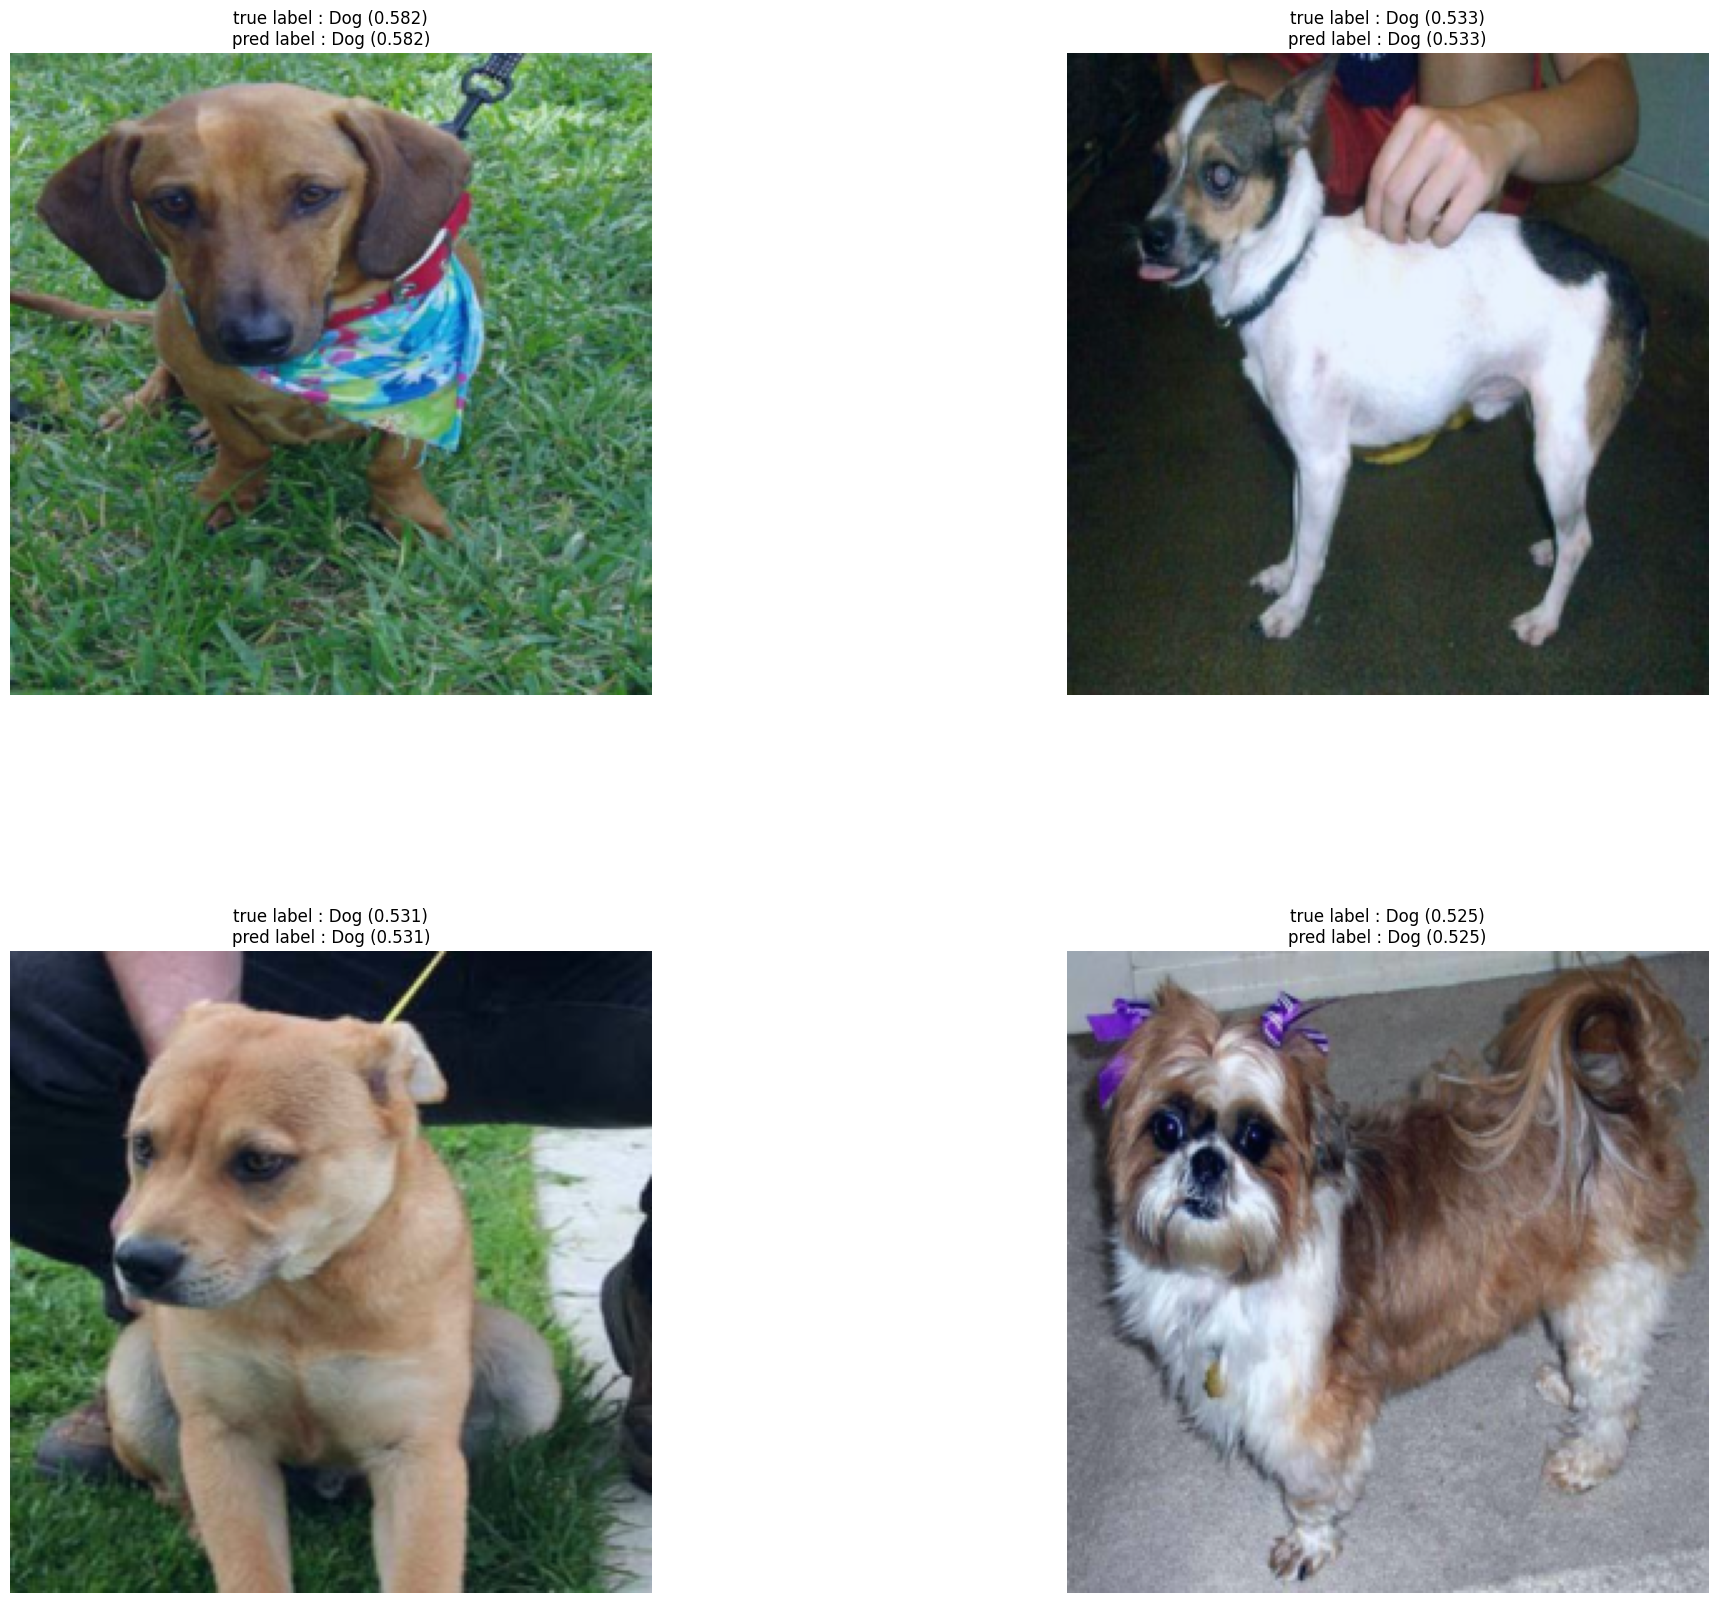

In [45]:
classes=test_dataset.classes
N_IMAGES=5
plot_most_correct(correct_examples, classes, N_IMAGES)

# **6.1.4 GoogLeNet**